Run the following two cells to download the dataset

In [ ]:
!gdown 1qaX-Ii_DyVSNgcs8jwUNhLpNXRhxiZuW

Downloading...
From: https://drive.google.com/uc?id=1qaX-Ii_DyVSNgcs8jwUNhLpNXRhxiZuW
To: /content/bangle.zip
100% 1.41G/1.41G [00:07<00:00, 196MB/s]


In [ ]:
!unzip -q '/content/bangle.zip'

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import keras
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model, load_model
from tensorflow import expand_dims
import shutil

In [ ]:

DATASET_DIR = '/content/dataset'



In [ ]:
!rm -r /content/dataset/broken

In [ ]:
# create train and test directories for anomaly and good classes
for folder in ["train", "test"]:
  os.makedirs(f"{DATASET_DIR}/{folder}", exist_ok = True)
  os.makedirs(f"{DATASET_DIR}/{folder}/anomaly", exist_ok = True)
  os.makedirs(f"{DATASET_DIR}/{folder}/good", exist_ok = True)

In [ ]:
# prepare train and test datset for the given data
def prepare_dataset(good_folder_name, DATASET_DIR=DATASET_DIR ):
  
  print(f"Dataset directory is : {DATASET_DIR}")


  # separate good and anomaly img paths
  good_img_paths , anomaly_img_paths = [] , []

  # first get the anomaly ones
  for folder in os.listdir(DATASET_DIR):
    if folder in ['train', 'test']:
      continue


    if not folder in [good_folder_name]:
      img_paths = os.listdir(path=f"{DATASET_DIR}/{folder}")
      for img_path in img_paths :
        anomaly_img_paths.append(f"{DATASET_DIR}/{folder}/{img_path}")
    
  # now prepare the good ones
  for img_path in os.listdir(f"{DATASET_DIR}/{good_folder_name}") :
    good_img_paths.append(f"{DATASET_DIR}/{good_folder_name}/{img_path}")


  print(f"Total anomaly images found : {len(anomaly_img_paths)}")
  print(f"Total good images found : {len(good_img_paths)}")


  # move 80% of the good imgs to train/good folder
  for good_img_path in good_img_paths[:round(len(good_img_paths)* 0.8)] : 
    shutil.move(good_img_path, f"{DATASET_DIR}/train/good")

  print(f"Training good imgs found : {len(os.listdir(f'{DATASET_DIR}/train/good'))}")

  # move 80% of the anomaly imgs to train/anomaly folder
  for anomaly_img_path in anomaly_img_paths[:round(len(anomaly_img_paths)* 0.8)] : 
    shutil.move(anomaly_img_path, f"{DATASET_DIR}/train/anomaly")

  print(f"Training anomaly imgs found : {len(os.listdir(f'{DATASET_DIR}/train/anomaly'))}")


  # move the rest of the imgs to test folder
  for good_img_path in good_img_paths:
    try : 
      shutil.move(good_img_path, f"{DATASET_DIR}/test/good") 
    except Exception as e:
      continue

  print(f"Testing good imgs found : {len(os.listdir(f'{DATASET_DIR}/test/good'))}")

  for anomaly_img_path in anomaly_img_paths:
    try :
      shutil.move(anomaly_img_path, f"{DATASET_DIR}/test/anomaly")  
    except Exception as e:
      continue

  print(f"Testing anomaly imgs found : {len(os.listdir(f'{DATASET_DIR}/test/anomaly'))}")      


                              
      
  


In [ ]:
prepare_dataset(good_folder_name = 'good')

In [2]:
size = 256
INPUT_IMG_SHAPE = (size,size,3)
IMG_SIZE = (size, size)

In [ ]:
# customize the model 
def custom_model(INPUT_IMG_SHAPE=INPUT_IMG_SHAPE):
  # define the base model
  base_model = VGG16(weights='imagenet', include_top=False, input_shape = INPUT_IMG_SHAPE)

  # freeze the model
  base_model.trainable = False

  # create new model on top
  inputs = keras.Input(shape=INPUT_IMG_SHAPE)

  x = base_model(inputs, training=False)
  x = GlobalAveragePooling2D()(x)

  x = Dense(units=1, activation='relu')(x)
  output = Dense(units=2, activation='softmax')(x)

  model = Model(inputs , output)

  return model


In [3]:
def convert_img_to_array(img_path, img_size = IMG_SIZE):
  img = load_img(path=img_path, color_mode='rgb', target_size = img_size)
  img = img_to_array(img)
  return img

In [ ]:
train_data_gen = ImageDataGenerator(validation_split = 0.2)
train_data = train_data_gen.flow_from_directory(
    f"{DATASET_DIR}",
    target_size = IMG_SIZE,
    subset = 'training'
)

Found 612 images belonging to 2 classes.


In [ ]:
test_data = train_data_gen.flow_from_directory(
    f"{DATASET_DIR}",
    target_size = IMG_SIZE,
    subset = 'validation'
)

Found 152 images belonging to 2 classes.


In [ ]:
model = custom_model()

In [ ]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_10  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                                 
 dense_21 (Dense)            (None, 2)                 4         
                                                                 
Total params: 14,715,205
Trainable params: 517
Non-trainable params: 14,714,688
____________________________________________

In [ ]:
for layer in model.layers :
  print(f"{layer.name} : {layer.trainable}")

input_28 : True
vgg16 : False
global_average_pooling2d_10 : True
dense_20 : True
dense_21 : True


In [ ]:
# get the vgg block of the model
vgg_block = model.get_layer(name='vgg16')

In [ ]:
vgg_block.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# experiment : delete input14 from vgg_block
vgg_block.layers[0].name

'input_27'

In [ ]:
for layer in vgg_block.layers:
  print(f"{layer.name} : {layer.trainable}")

input_27 : False
block1_conv1 : False
block1_conv2 : False
block1_pool : False
block2_conv1 : False
block2_conv2 : False
block2_pool : False
block3_conv1 : False
block3_conv2 : False
block3_conv3 : False
block3_pool : False
block4_conv1 : False
block4_conv2 : False
block4_conv3 : False
block4_pool : False
block5_conv1 : False
block5_conv2 : False
block5_conv3 : False
block5_pool : False


In [ ]:
# set last 4 layers trainable, i.e., from block5_conv1
for layer in vgg_block.layers[-8:] :
  layer.trainable = True

In [ ]:
for layer in vgg_block.layers:
  print(f"{layer.name} : {layer.trainable}")

input_27 : False
block1_conv1 : False
block1_conv2 : False
block1_pool : False
block2_conv1 : False
block2_conv2 : False
block2_pool : False
block3_conv1 : False
block3_conv2 : False
block3_conv3 : False
block3_pool : False
block4_conv1 : True
block4_conv2 : True
block4_conv3 : True
block4_pool : True
block5_conv1 : True
block5_conv2 : True
block5_conv3 : True
block5_pool : True


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_data, epochs=20, batch_size = 32 )

Epoch 1/20
24/24 [==============================] - 94s 4s/step - loss: 0.7975 - accuracy: 0.6243
Epoch 2/20
24/24 [==============================] - 91s 4s/step - loss: 0.6821 - accuracy: 0.6806
Epoch 3/20
24/24 [==============================] - 93s 4s/step - loss: 0.6758 - accuracy: 0.6806
Epoch 4/20
24/24 [==============================] - 92s 4s/step - loss: 0.6695 - accuracy: 0.6806
Epoch 5/20
24/24 [==============================] - 93s 4s/step - loss: 0.6644 - accuracy: 0.6806
Epoch 6/20
24/24 [==============================] - 91s 4s/step - loss: 0.6595 - accuracy: 0.6806
Epoch 7/20
24/24 [==============================] - 92s 4s/step - loss: 0.6553 - accuracy: 0.6806
Epoch 8/20
24/24 [==============================] - 92s 4s/step - loss: 0.6513 - accuracy: 0.6806
Epoch 9/20
24/24 [==============================] - 92s 4s/step - loss: 0.6482 - accuracy: 0.6806
Epoch 10/20
24/24 [==============================] - 92s 4s/step - loss: 0.6451 - accuracy: 0.6806
Epoch 11/20
24/24 [

In [ ]:
model.evaluate(test_data)

23/23 [==============================] - 8s 324ms/step - loss: 0.2266 - accuracy: 0.8778


[0.22659237682819366, 0.8777777552604675]

In [ ]:
model.save('LEATHER.h5')

In [4]:
# get the model from drive link
!gdown 1GZ-0YMxLOaLnHz1hB8GJR3SkCQmuyOx3

Downloading...
From: https://drive.google.com/uc?id=1GZ-0YMxLOaLnHz1hB8GJR3SkCQmuyOx3
To: /content/bangle.h5
100% 80.2M/80.2M [00:01<00:00, 70.0MB/s]


In [5]:
model = load_model('/content/bangle.h5')

In [6]:
for layer in model.layers:
  print(f"{layer.name}")

input_6
vgg19
global_average_pooling2d_1
dense_2
dense_3


In [7]:
vgg_layer = model.get_layer(name='vgg19')

In [8]:
vgg_layer.layers[-2].output

<KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'block5_conv4')>

In [9]:
# get the feature maps

feature_map_model = Model(inputs = vgg_layer.inputs, outputs = vgg_layer.layers[-2].output)

In [10]:
from keras.utils import load_img, img_to_array
from keras.backend import expand_dims
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

In [11]:
IMG_PATH = "/content/img5004.jpg"

In [12]:
img = load_img(path=IMG_PATH,
               target_size = IMG_SIZE)

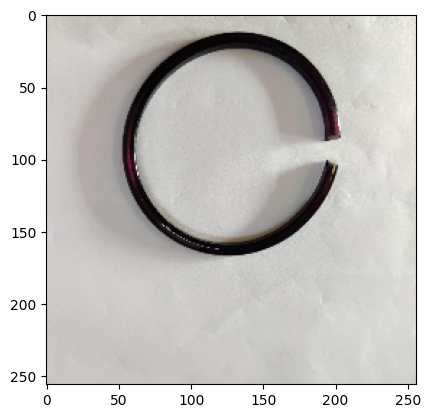

In [13]:
plt.imshow(img)

In [14]:
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)

In [15]:
model.predict(img)

1/1 [==============================] - 8s 8s/step


array([[0.9943045 , 0.00569552]], dtype=float32)

In [16]:
feature_map = feature_map_model.predict(img)

1/1 [==============================] - 0s 311ms/step


In [17]:
feature_map.shape

(1, 16, 16, 512)

In [18]:
feature_imgs = feature_map[0]
feature_imgs.shape

(16, 16, 512)

feature_imgs contains 512 feature maps each of size of (16,16)

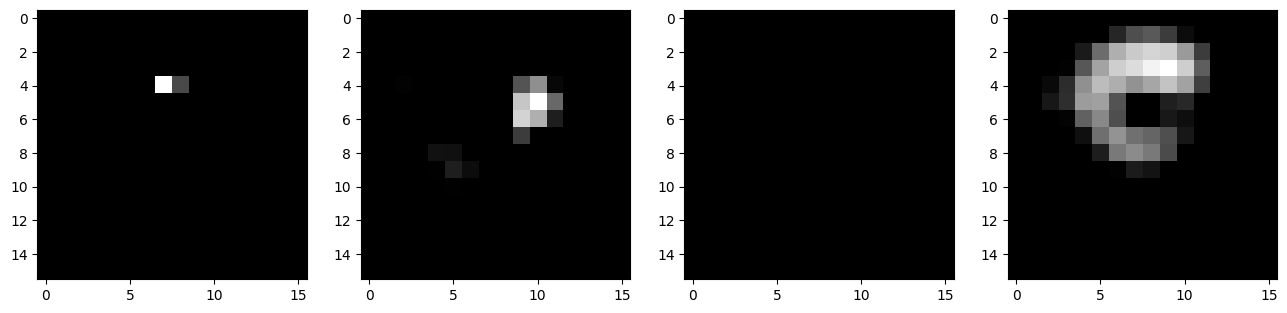

In [31]:
fig , axes = plt.subplots(nrows=1,ncols=4 ,figsize=(16,16))
for i in range(0,4):
  feature_img = feature_imgs[:,:,i]
  axes[i].imshow(feature_img, cmap='gray')

In [32]:
wts_layer = model.get_layer(name=model.layers[-2].name)
wts = wts_layer.get_weights()[0]
wts.shape

(512, 1)

In [33]:
# multiply weights to corresponding feature maps
resultant_img = np.zeros(shape = (feature_imgs.shape[0], feature_imgs.shape[1]))
for i in range(0,wts.shape[0]):
  weight = wts[i][0]
  feature_img = feature_imgs[:, : , i]
  resultant_img += weight * feature_img


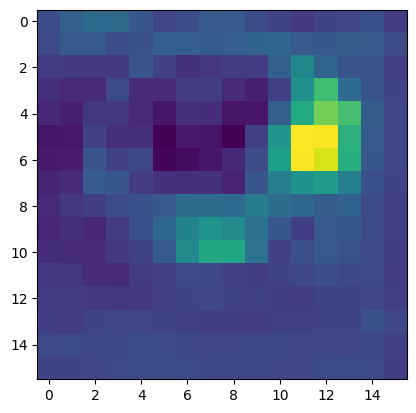

In [34]:
import matplotlib.pyplot as plt
plt.imshow(resultant_img)

In [35]:
from skimage.transform import resize
resized_img = resize(resultant_img, output_shape=(128,128))

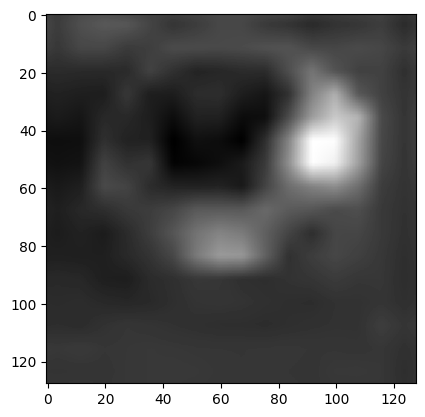

In [36]:
plt.imshow(resized_img, cmap='gray')

In [37]:
normalized_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min() )

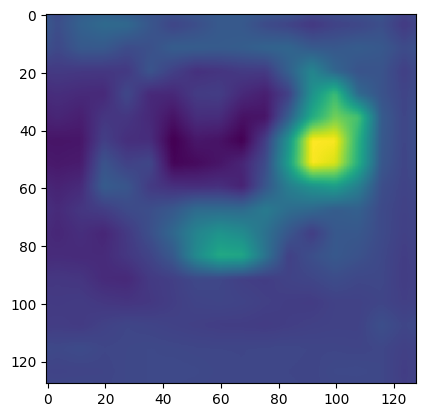

In [38]:
plt.imshow(normalized_img)

In [39]:
THRESHOLD = 0.7
defect_img = normalized_img > THRESHOLD

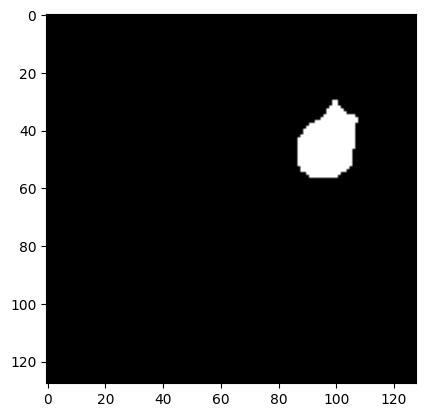

In [40]:
plt.imshow(defect_img , cmap = 'gray')

In [41]:
import numpy as np
# extract the column numbers which have the defect part
x_dim = np.max(defect_img , axis=0) * np.arange(0, defect_img.shape[1])
x_dim

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [42]:
# extract the boundary columns
x_0 = (x_dim[x_dim > 0]).min()
x_1 = (x_dim[x_dim > 0]).max()
print(x_0, x_1)

87 107


In [43]:
# extract the row numbers which have the defect part
y_dim = np.max(defect_img, axis=1) * np.arange(0, defect_img.shape[1])
y_dim

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [44]:
y_0 = (y_dim[y_dim > 0]).min()
y_1 = (y_dim[y_dim > 0]).max()
print(y_0, y_1)

30 56


In [45]:
# rectangle coordinates
pt1 = (x_0, y_0)
pt2 = (x_1, y_1)

In [46]:
import cv2

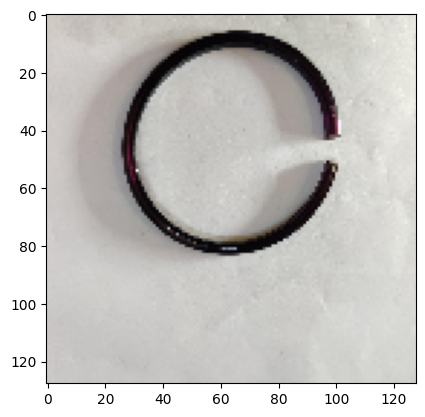

In [47]:
original_img = load_img(path=IMG_PATH,
               target_size = (defect_img.shape[0], defect_img.shape[1]))
plt.imshow(original_img)

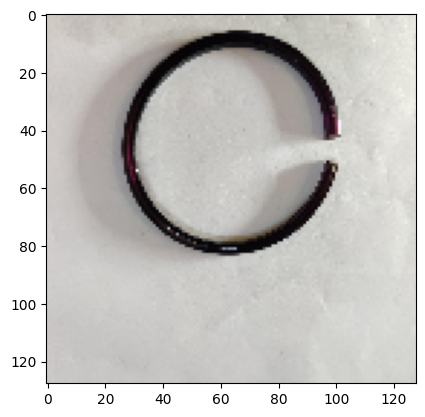

In [48]:
# copy image to new variable
new_img = np.copy(original_img)
plt.imshow(new_img)

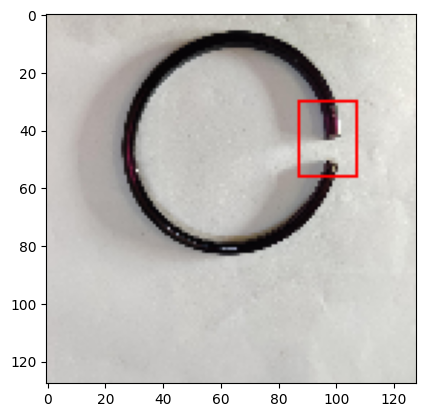

In [49]:
cv2.rectangle(new_img, pt1, pt2, color=(255,0,0))
plt.imshow(new_img)

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input

In [ ]:
model = VGG19(
    include_top = False, weights = 'imagenet', input_shape = INPUT_IMG_SHAPE
)

In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# customize the model 
def custom_model2(INPUT_IMG_SHAPE=INPUT_IMG_SHAPE):
  # define the base model
  base_model = VGG19(weights='imagenet', include_top=False, input_shape = INPUT_IMG_SHAPE)

  # freeze the model
  base_model.trainable = False

  # create new model on top
  inputs = keras.Input(shape=INPUT_IMG_SHAPE)

  x = base_model(inputs, training=False)
  x = GlobalAveragePooling2D()(x)

  x = Dense(units=1, activation='relu')(x)
  output = Dense(units=2, activation='softmax')(x)

  model = Model(inputs , output)

  return model

In [ ]:
model = custom_model2()

In [ ]:
for layer in model.layers:
  print(f"{layer.name} : {layer.trainable}")

input_6 : True
vgg19 : False
global_average_pooling2d_1 : True
dense_2 : True
dense_3 : True


In [ ]:
vgg = model.layers[1]

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
for layer in vgg.layers[-10:]:
  layer.trainable = True

In [ ]:
for layer in vgg.layers:
  print(f"{layer.name} : {layer.trainable}")

input_5 : False
block1_conv1 : False
block1_conv2 : False
block1_pool : False
block2_conv1 : False
block2_conv2 : False
block2_pool : False
block3_conv1 : False
block3_conv2 : False
block3_conv3 : False
block3_conv4 : False
block3_pool : False
block4_conv1 : True
block4_conv2 : True
block4_conv3 : True
block4_conv4 : True
block4_pool : True
block5_conv1 : True
block5_conv2 : True
block5_conv3 : True
block5_conv4 : True
block5_pool : True


In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(train_data, epochs=50, batch_size=32)

Epoch 1/50
20/20 [==============================] - 80s 4s/step - loss: 0.6887 - accuracy: 0.6977
Epoch 2/50
20/20 [==============================] - 76s 4s/step - loss: 0.6516 - accuracy: 0.7778
Epoch 3/50
20/20 [==============================] - 75s 4s/step - loss: 0.6296 - accuracy: 0.8072
Epoch 4/50
20/20 [==============================] - 75s 4s/step - loss: 0.6117 - accuracy: 0.8268
Epoch 5/50
20/20 [==============================] - 75s 4s/step - loss: 0.5943 - accuracy: 0.8317
Epoch 6/50
20/20 [==============================] - 75s 4s/step - loss: 0.5803 - accuracy: 0.8497
Epoch 7/50
20/20 [==============================] - 74s 4s/step - loss: 0.5667 - accuracy: 0.8529
Epoch 8/50
20/20 [==============================] - 75s 4s/step - loss: 0.5542 - accuracy: 0.8578
Epoch 9/50
20/20 [==============================] - 74s 4s/step - loss: 0.5432 - accuracy: 0.8644
Epoch 10/50
20/20 [==============================] - 74s 4s/step - loss: 0.5297 - accuracy: 0.8660
Epoch 11/50
20/20 [

In [ ]:
model.save('bangle.h5')

In [ ]:
# download the model
!gdown 1GZ-0YMxLOaLnHz1hB8GJR3SkCQmuyOx3

Downloading...
From: https://drive.google.com/uc?id=1GZ-0YMxLOaLnHz1hB8GJR3SkCQmuyOx3
To: /content/bangle.h5
100% 80.2M/80.2M [00:01<00:00, 46.0MB/s]


In [ ]:
model = load_model('/content/bangle.h5')

In [ ]:
from keras.utils import load_img, img_to_array
from keras.backend import expand_dims
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

In [ ]:
path='/content/img5004.jpg'

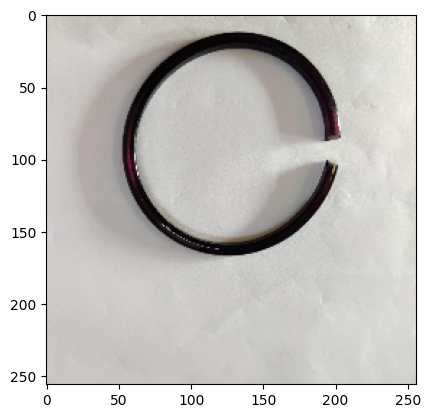

In [ ]:
img = load_img(path, target_size = (256,256))
plt.imshow(img)

In [ ]:
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

In [ ]:
model.predict(img)

1/1 [==============================] - 1s 878ms/step


array([[0.9943045 , 0.00569549]], dtype=float32)

In [ ]:
vgg_layer = model.get_layer(name='vgg19')

In [ ]:
vgg_layer.layers[-2].name

'block5_conv4'

In [ ]:
# get the feature maps

feature_map_model = Model(inputs = vgg_layer.inputs, outputs = vgg_layer.layers[-2].output)

In [ ]:
feature_map = feature_map_model.predict(img)

1/1 [==============================] - 2s 2s/step


In [ ]:
feature_map.shape

(1, 16, 16, 512)

In [ ]:
feature_imgs = feature_map[0]
feature_imgs.shape

(16, 16, 512)

feature_imgs contains 512 feature maps each of size of (16,16)

In [ ]:
wts_layer = model.get_layer(name=model.layers[-2].name)
wts = wts_layer.get_weights()[0]
wts.shape

(512, 1)

In [ ]:
# multiply weights to corresponding feature maps
resultant_img = np.zeros(shape = (feature_imgs.shape[0], feature_imgs.shape[1]))
for i in range(0,wts.shape[0]):
  weight = wts[i][0]
  feature_img = feature_imgs[:, : , i]
  resultant_img += weight * feature_img


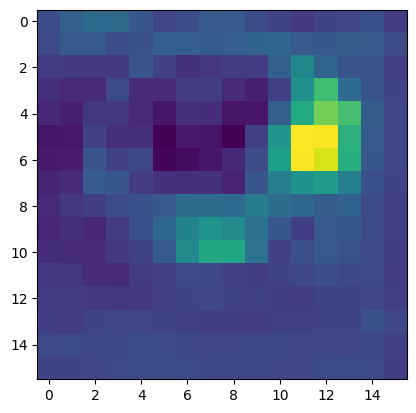

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(resultant_img)

In [ ]:
from skimage.transform import resize
resized_img = resize(resultant_img, output_shape=(128,128))

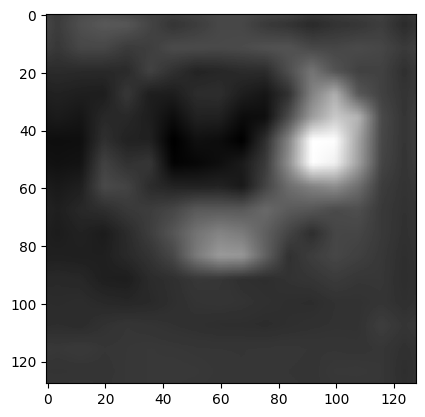

In [ ]:
plt.imshow(resized_img, cmap='gray')

In [ ]:
normalized_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min() )

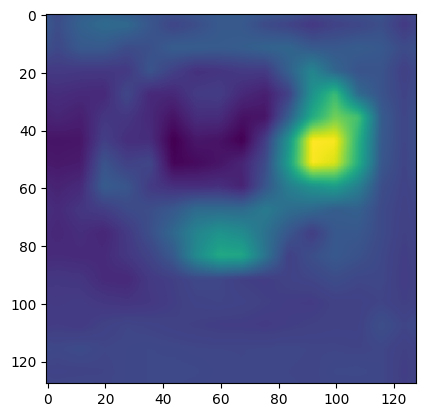

In [ ]:
plt.imshow(normalized_img)

In [ ]:
THRESHOLD = 0.8
defect_img = normalized_img > THRESHOLD

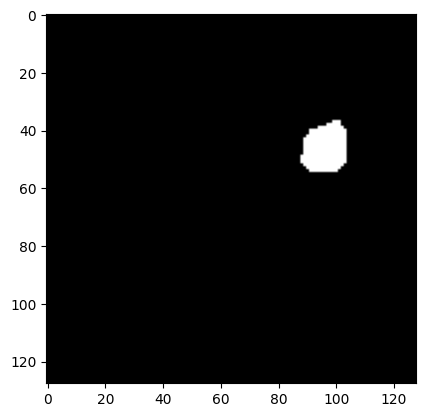

In [ ]:
plt.imshow(defect_img , cmap = 'gray')

In [ ]:
import numpy as np
# extract the column numbers which have the defect part
x_dim = np.max(defect_img , axis=0) * np.arange(0, defect_img.shape[1])
x_dim

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [ ]:
# extract the boundary columns
x_0 = (x_dim[x_dim > 0]).min()
x_1 = (x_dim[x_dim > 0]).max()
print(x_0, x_1)

88 103


In [ ]:
# extract the row numbers which have the defect part
y_dim = np.max(defect_img, axis=1) * np.arange(0, defect_img.shape[1])
y_dim

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
y_0 = (y_dim[y_dim > 0]).min()
y_1 = (y_dim[y_dim > 0]).max()
print(y_0, y_1)

37 54


In [ ]:
# rectangle coordinates
pt1 = (x_0, y_0)
pt2 = (x_1, y_1)

In [ ]:
import cv2

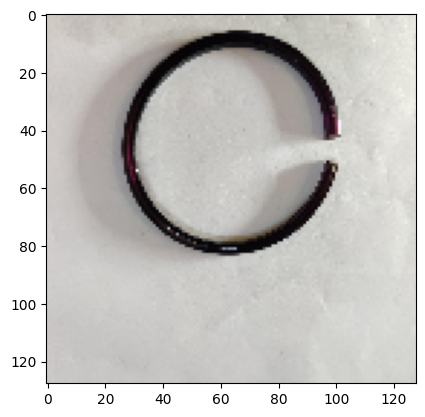

In [ ]:
original_img = load_img(path=path,
               target_size = (defect_img.shape[0], defect_img.shape[1]))
plt.imshow(original_img)

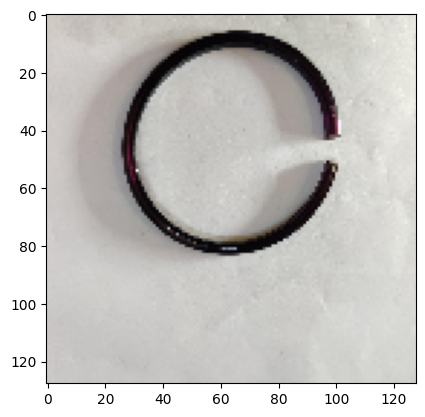

In [ ]:
# copy image to new variable
new_img = np.copy(original_img)
plt.imshow(new_img)

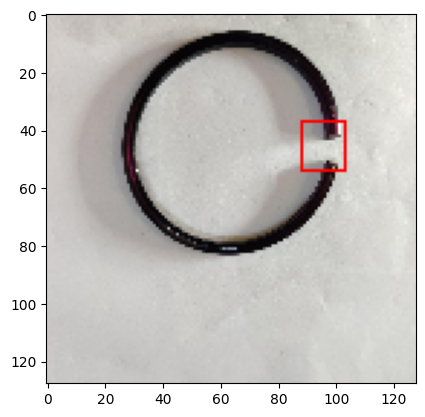

In [ ]:
cv2.rectangle(new_img, pt1, pt2, color=(255,0,0))
plt.imshow(new_img)